In [4]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [5]:
# import data
df = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/automobile.csv')

In [6]:
df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

## Data processing

In [7]:
df.sample(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
129,2,104.0,saab,gas,std,four,sedan,fwd,front,99.1,...,121,mpfi,3.54,3.07,9.3,110,5250,21,28,12170
76,1,161.0,mitsubishi,gas,turbo,two,hatchback,fwd,front,93.0,...,98,spdi,3.03,3.39,7.6,102,5500,24,30,7689
119,1,154.0,plymouth,gas,std,four,sedan,fwd,front,93.7,...,98,2bbl,2.97,3.23,9.4,68,5500,31,38,7609
102,3,194.0,nissan,gas,turbo,two,hatchback,rwd,front,91.3,...,181,mpfi,3.43,3.27,7.8,200,5200,17,23,19699
77,3,153.0,mitsubishi,gas,turbo,two,hatchback,fwd,front,96.3,...,110,spdi,3.17,3.46,7.5,116,5500,23,30,9959


In [8]:
df.shape

(202, 26)

In [9]:
# remove rows with '?'
df = df[df['bore']!='?']
df = df[df['stroke']!='?']
df = df[df['horsepower']!='?']
df = df[df['peak-rpm']!='?']

In [10]:
# convert data type
df['bore'] = df['bore'].astype('float')
df['stroke'] = df['stroke'].astype('float')
df['horsepower'] = df['horsepower'].astype('int')
df['peak-rpm'] = df['peak-rpm'].astype('int')

In [11]:
cat_cols = df.select_dtypes(include='O').columns.to_list()
df[cat_cols] = df[cat_cols].astype('category')

# Feature selection strategies

### Unused columns

In [ ]:
# df = df.drop(columns=['Id'])

### Columns with missing values

In [12]:
# total null values per column
df.isnull().sum()

symboling             0
normalized-losses    35
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  0
stroke                0
compression-ratio     0
horsepower            0
peak-rpm              0
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [13]:
# drop column
df = df.drop(['normalized-losses'], axis=1)

In [14]:
# remaining number of columns
len(df.columns)

25

### Uncorrelated features

#### a) Numeric features

<AxesSubplot:>

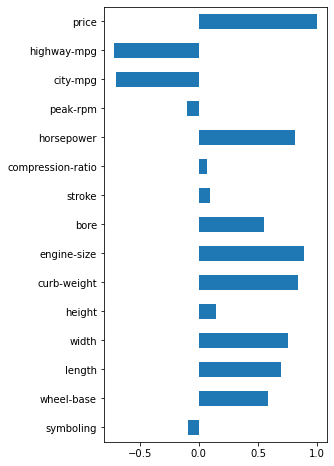

In [17]:
# correlation between y and features
(df.corr().loc['price']
 .plot(kind='barh', figsize=(4,8))) 

In [18]:
# drop numeric features  not correlation with the target (threshold <0.2)
corr = abs(df.corr().loc['price'])
corr = corr[corr<0.2]
cols_to_drop = corr.index.to_list()
df = df.drop(cols_to_drop, axis=1)

In [19]:
len(df.columns)

20

#### b) Categorical features

<AxesSubplot:xlabel='fuel-type', ylabel='price'>

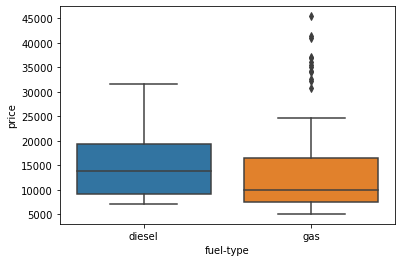

In [20]:
sns.boxplot(y = 'price', x = 'fuel-type', data=df)

### Low varience features

In [21]:
# variance of numeric features
(df
 .select_dtypes(include=np.number)
 .var()
 .astype('str'))

wheel-base       37.94025405546827
length           155.9424623233909
width            4.570510465724747
curb-weight      275205.6007064364
engine-size      1708.835871271584
bore           0.07456791993720567
horsepower      1427.3492412349553
city-mpg         40.97485609628467
highway-mpg      46.57443746729464
price            65020222.64615383
dtype: object

In [22]:
df['bore'].describe()

count    196.000000
mean       3.331684
std        0.273071
min        2.540000
25%        3.150000
50%        3.310000
75%        3.590000
max        3.940000
Name: bore, dtype: float64

### Multicolinearity

#### a) Numeric features

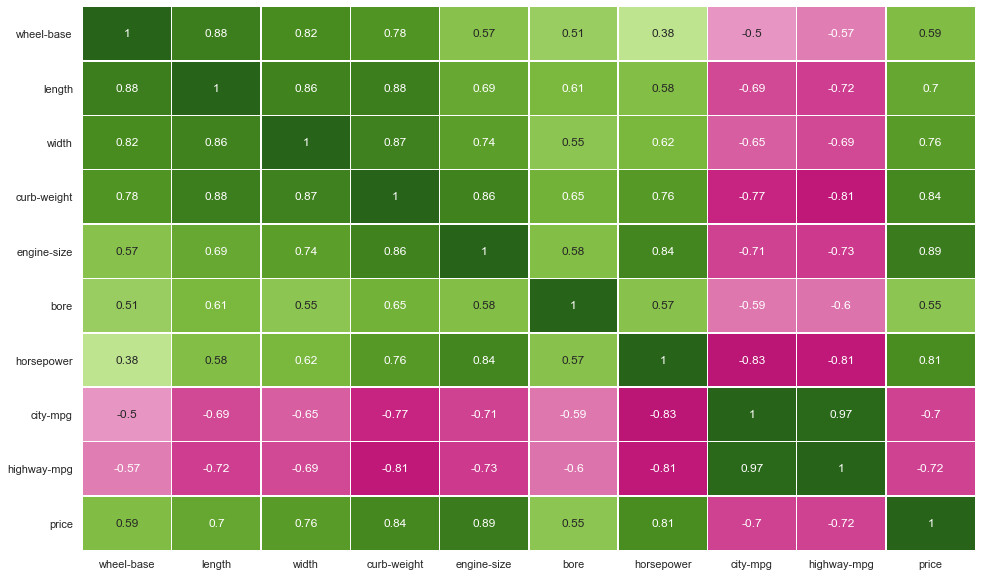

In [23]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="PiYG")
plt.show()

In [24]:
# drop correlated features
df = df.drop(['length', 'width', 'curb-weight', 'engine-size', 'city-mpg'], axis=1)

In [25]:
len(df.columns)

15

#### b) Categorical variables

In [26]:
df_cat = df[['fuel-type', 'body-style']]
df_cat.sample(5)

,fuel-type,body-style
119,gas,sedan
138,gas,sedan
42,gas,sedan
193,gas,wagon
48,gas,hatchback


In [27]:
crosstab = pd.crosstab(df_cat['fuel-type'], df_cat['body-style'])
crosstab

body-style,convertible,hardtop,hatchback,sedan,wagon
fuel-type,,,,,
diesel,0,1,1,15,3
gas,6,7,62,80,21


In [28]:
from scipy.stats import chi2_contingency
chi2_contingency(crosstab)

(9.205409356725148,
 0.05616535232132477,
 4,
 array([[ 0.6122449 ,  0.81632653,  6.42857143,  9.69387755,  2.44897959],
        [ 5.3877551 ,  7.18367347, 56.57142857, 85.30612245, 21.55102041]]))

---

# PART 2

In [29]:
# drop rows with missing values
df = df.dropna()

In [30]:
# get dummies for categorical features
df = pd.get_dummies(df, drop_first=True)

In [31]:
# X features
X = df.drop('price', axis=1)

# y target
y = df['price']

In [32]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [34]:
# convert back to dataframe
X_train = pd.DataFrame(X_train, columns = X.columns.to_list())
X_test = pd.DataFrame(X_test, columns = X.columns.to_list())

### Feature coefficients

In [35]:
# instantiate model
model = LinearRegression() 

In [36]:
# fit
model.fit(X_train, y_train)

LinearRegression()

<AxesSubplot:>

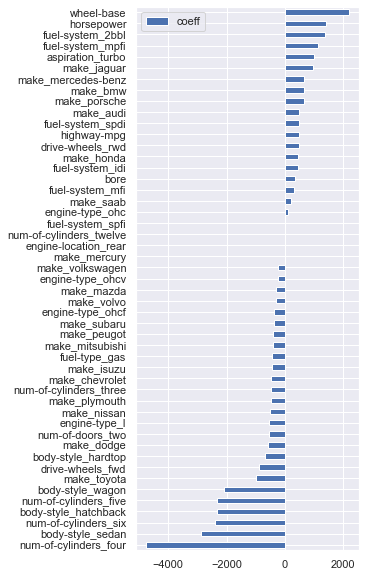

In [37]:
# feature coefficients
coeffs = model.coef_

# visualizing coefficients
index = X_train.columns.tolist()

(pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
 .plot(kind='barh', figsize=(4,10)))

# add this to regression notebook

In [38]:
# filter variables near zero coefficient value
temp = pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
temp = temp[(temp['coeff']>1) | (temp['coeff']< -1)]

# drop features
cols_coeff = temp.index.to_list()
X_train = X_train[cols_coeff]
X_test = X_test[cols_coeff]

### _p_ value

In [39]:
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     62.39
Date:                Sat, 14 May 2022   Prob (F-statistic):           2.82e-76
Time:                        18:04:20   Log-Likelihood:                -1727.5
No. Observations:                 194   AIC:                             3549.
Df Residuals:                     147   BIC:                             3703.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
wheel-base                

### Variance Inflation Factor (VIF)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

d:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [41]:
index = X_train.columns.tolist()
vif_df = pd.DataFrame(vif, index = index, columns = ['vif']).sort_values(by = 'vif', ascending=False)
vif_df[vif_df['vif']<10]

,vif
engine-type_ohc,9.832494
body-style_wagon,9.788068
make_mitsubishi,9.725685
highway-mpg,9.344857
wheel-base,8.932013
fuel-system_spdi,8.894106
make_bmw,8.729793
make_volkswagen,8.326544
make_mazda,8.291162
make_porsche,7.522600


### Feature importance/impurity based feature selection

In [ ]:
# instantiate model
model = RandomForestClassifier(n_estimators=200, random_state=0)
# fit model
model.fit(X,y)

In [ ]:
#  feature importance
importances = model.feature_importances_

# visualization
cols = X.columns
(pd.DataFrame(importances, cols, columns = ['importance'])
 .sort_values(by='importance', ascending=True)
 .plot(kind='barh', figsize=(4,10))
);

In [ ]:
# calculate standard deviation of feature importances 
std = np.std([i.feature_importances_ for i in model.estimators_], axis=0)

# visualization
feat_with_importance  = pd.Series(importances, X.columns)
fig, ax = plt.subplots(figsize=(12,5))
feat_with_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Automated feature selection with `sci-kit learn` 

In [ ]:
# import modules
from sklearn.feature_selection import (SelectKBest, chi2, SelectPercentile, SelectFromModel, 
                                       SequentialFeatureSelector, SequentialFeatureSelector)
                                       

#### a) Chi-squared based technique

In [ ]:
# select K best features
X_best = SelectKBest(chi2, k=10).fit_transform(X,y) 

In [ ]:
# number of best features
X_best.shape[1]

In [ ]:
# keep 75% top features 
X_top = SelectPercentile(chi2, percentile = 75).fit_transform(X,y)

# number of best features
X_top.shape[1]

#### b) Regularization

In [ ]:
# implement algorithm
from sklearn.svm import LinearSVC
model = LinearSVC(penalty= 'l1', C = 0.002, dual=False)
model.fit(X,y)

In [ ]:
# select features using the meta transformer
selector = SelectFromModel(estimator = model, prefit=True)

In [ ]:
X_new = selector.transform(X)

In [ ]:
X_new.shape[1]

In [ ]:
# names of selected features
feature_names = np.array(X.columns)
feature_names[selector.get_support()]

#### c) Sequential selection

In [ ]:
# instantiate model
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [ ]:
# select features
selector = SequentialFeatureSelector(estimator=model, n_features_to_select=10, direction='backward', cv=2)

In [ ]:
selector.fit_transform(X,y)

In [ ]:
# names of features selected
feature_names = np.array(X.columns)
feature_names[selector.get_support()]

### Principal Compoenent Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# scaling data
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA()
pca.fit(X_scaled)
evr = pca.explained_variance_ratio_

In [ ]:
# visualizing the variance explained by each principal components

plt.figure(figsize=(12, 5))
plt.plot(range(0, len(evr)), evr.cumsum(), marker="o", linestyle="--")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")